In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

## Data

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-06'),
    val_days=5,
    split='train',
    pure_sr_ratio=8, 
    tp_log=0.01
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='valid',
    mins=ds_train.mins,
    maxs=ds_train.maxs,
    pure_sr_ratio=8,
    tp_log= 0.01
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [8]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=8, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=8, sampler=sampler_valid)

In [9]:
len(ds_train), len(dl_train)

(9972, 1247)

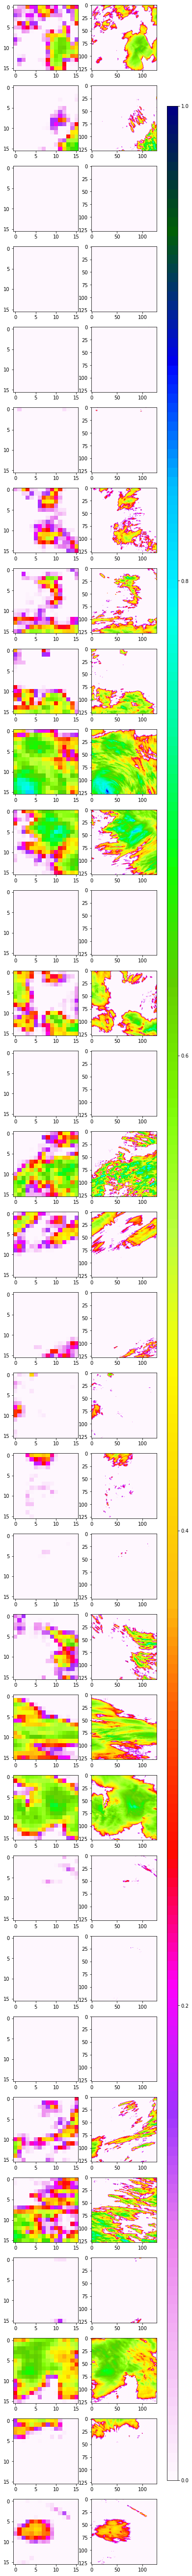

In [14]:
X, y = next(iter(dl_train))
fig, axs = plt.subplots(32, 2, figsize=(6, 96))
for x, ax in zip([val for pair in zip(X.numpy(), y.numpy()) for val in pair], axs.flat):
    im = ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

## Networks

In [17]:
gen = Generator(
    nres=3, nf_in=1, nf=32, use_noise=True, spectral_norm=True
).to(device)

In [20]:
disc = Discriminator2(
    64, sigmoid=False, spectral_norm=True, nres=2
).to(device)

In [21]:
gen = gen.apply(weights_init_normal)
disc = disc.apply(weights_init_normal)

In [22]:
betas = (0.5, 0.999)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=5e-6, betas=betas)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=5e-5, betas=betas)

In [15]:
X, y = next(iter(dl_train))

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


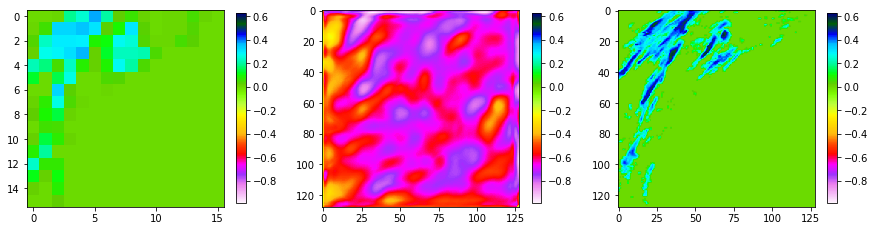

In [24]:
plot_sample(X, y, gen, 0)

In [16]:
X_sample, y_sample = X, y

## Pretrain

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [27]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [28]:
trainer.fit(4)

In [31]:
torch.save(gen.state_dict(), f'ilan_gen_pretrained.pt')
# gen.load_state_dict(torch.load('gen_pretrained.pt'))

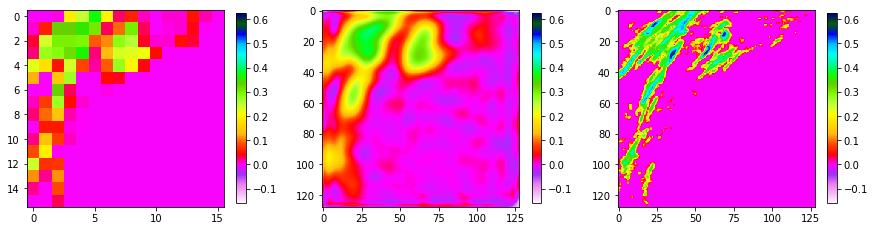

In [32]:
plot_sample(X_sample, y_sample, gen, 0)

## Trainer

In [33]:
trainer = GANTrainer(
    gen, disc, gen_optimizer, disc_optimizer, dl_train, gen_repeats=4, l_loss='l1', 
    adv_loss_type='Wasserstein',
    l_lambda=5, plot=True, plotting_sample=(X_sample, y_sample)
)

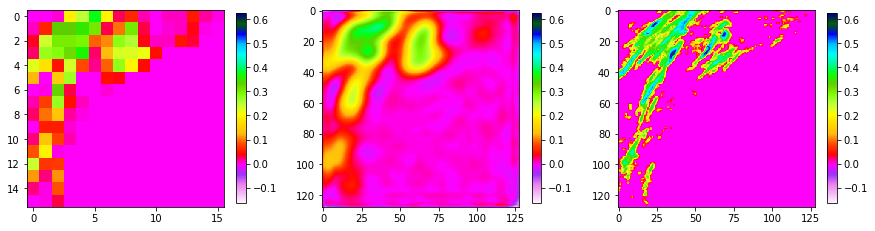

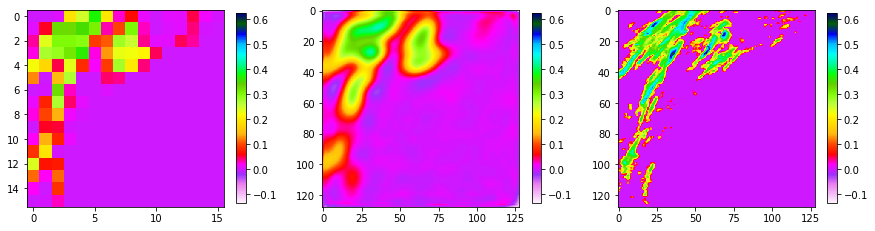

KeyboardInterrupt: 

In [34]:
trainer.fit(20)

# Ilan first gan

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import tqdm, device
from src.layers import *

In [82]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes=256, planes=256, stride=1, nonlin = 'relu'):
        super(BasicBlock, self).__init__()
        self.nonlin = nonlin
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        if self.nonlin == 'leaky_relu':
            out = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.02)
            out = self.bn2(self.conv2(out))
            out = out + self.shortcut(x)
            out = F.leaky_relu(out, negative_slope=0.02)
            return out
        elif self.nonlin == 'relu':
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out = out + self.shortcut(x)
            out = F.relu(out)
            return out
        else: raise NotImplementedError
            
class gen1(nn.Module):
    def __init__(self, block, device):
        super(gen1, self).__init__()
        self.conv1 = nn.Conv2d(1,248, kernel_size=3, padding=1)
        self.b1 = block(in_planes=256, planes=256, stride=1,  nonlin = 'relu')
        self.b2 = block(in_planes=256, planes=256, stride=1, nonlin = 'relu')
        self.b3 = block(in_planes=256, planes=256, stride=1, nonlin = 'relu')
        self.b4 = block(in_planes=256, planes=256, stride=1, nonlin = 'leaky_relu')
        self.b5 = block(in_planes=256, planes=128, stride=1, nonlin = 'leaky_relu')
        self.b6 = block(in_planes=128, planes=64, stride=1, nonlin = 'leaky_relu')
        self.b7 = block(in_planes=64, planes=32, stride=1, nonlin = 'leaky_relu')
        self.final = nn.Conv2d(32,1, kernel_size=3, padding=1)
        self.upscale = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
    def forward(self, x, noise):
#         noise = torch.randn(x.shape[0], 8, x.shape[2], x.shape[3]).to(device)
        x = F.relu(self.conv1(x))
        x = torch.cat((x,noise), axis=1)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(self.upscale(x))
        x = self.b6(self.upscale(x))
        x = self.b7(self.upscale(x))
        x = torch.sigmoid(self.final(x))
        return x
        

class disc1(nn.Module):
    def __init__(self, block):
        super(disc1, self).__init__()
        hr_block = []
        lr_block = []
        inplanes = 1
        for planes in [64, 128, 256]:
            hr_block.append(block(in_planes = inplanes, planes=planes, stride=2, nonlin = 'leaky_relu'))
            lr_block.append(block(in_planes = inplanes, planes=planes, stride=1, nonlin = 'leaky_relu'))
            inplanes=planes
        self.hr_block1 = nn.Sequential(*hr_block)
        self.lr_block1 = nn.Sequential(*lr_block)
        self.hr_block2 = nn.Sequential(block(in_planes=256, planes=256, stride=1, nonlin = 'leaky_relu'), block(in_planes=256, planes=256, stride=1, nonlin = 'leaky_relu'))
        self.lr_block2 = nn.Sequential(block(in_planes=512, planes=256, stride=1, nonlin = 'leaky_relu'),block(in_planes=256, planes=256, stride=1, nonlin = 'leaky_relu'))
        self.dense1 = nn.Linear(512, 256)
        self.dense2 = nn.Linear(256, 1)
        
    def initialise_weights(self):
        for m in self.modules:
            if type(m)== nn.Conv2d or type(m)==nn.Linear:
                torch.nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
    def forward(self, x):
        X, y = x[0], x[1]
        hr = self.hr_block1(y)
        lr = self.lr_block1(X)
        print(lr.shape)
        print(hr.shape)
        lr = torch.cat((lr,hr), axis=1)
        hr = self.hr_block2(hr)
        lr = self.lr_block2(lr)
        hr = nn.AvgPool2d(16)(hr)
        lr = nn.AvgPool2d(16)(lr)
        out = torch.cat((torch.squeeze(hr), torch.squeeze(lr)), axis=1)
        out = F.leaky_relu(self.dense1(out), negative_slope=0.02)
        out = self.dense2(out)
        return torch.sigmoid(out)
        

In [87]:
def loss_D(x,y,z,G,D,lam):
    fake = G(x,z)
    l = D(x,y) - D(x,fake) 
    def gradient_penalty(gradient):
        gradient = gradient.view(len(gradient), -1)
        gradient_norm = gradient.norm(2, dim=1)
        penalty = torch.mean((gradient_norm -1)**2)
        return penalty
    epsilon = torch.rand(len(y), 1, 1, 1, device=device, requires_grad=True)
    gradient = get_gradient(D, x, y, fake.detach(), epsilon)
    grad_penalty = grad_penalty(gradient)
    l+= lam*grad_penalty
    return l
    
def loss_G(x,z, D, G):
    return (D(x, G(x,z)))

In [ ]:
noise = torch.randn(X_sample.shape[0], 8, X_sample.shape[2], X_sample.shape[3])
loss_D(X_sample, y_sample, noise, G, D, )

In [83]:
G = gen1(BasicBlock, device).to(device)

In [84]:
D = disc1(BasicBlock).to(device)

In [85]:
X_sample[0,0,:,:]

tensor([[0.0000, 0.0000, 0.0000, 0.0024, 0.0194, 0.0756, 0.1043, 0.1263, 0.0525,
         0.2066, 0.3099, 0.3461, 0.3250, 0.2936, 0.3142, 0.3626],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0007,
         0.0632, 0.0909, 0.1127, 0.1685, 0.1854, 0.1346, 0.2548],
        [0.0000, 0.0000, 0.0105, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0022, 0.1406, 0.2822, 0.3333, 0.3454, 0.3540],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0239, 0.1495,
         0.2256, 0.1282, 0.2282, 0.3102, 0.3916, 0.4208, 0.3999],
        [0.0012, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0046, 0.0044,
         0.0313, 0.1371, 0.1338, 0.1925, 0.2334, 0.2754, 0.2612],
        [0.0043, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0279,
         0.1066, 0.1319, 0.2147, 0.2259, 0.2692, 0.3434, 0.3685],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0102, 0.1076,
         0.1521, 0.2737, 0.2895, 0.26

In [76]:
D([X_sample.to(device), G(X_sample.to(device))]) 

torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 16, 16])


tensor([[0.4887],
        [0.4709],
        [0.4802],
        [0.5241],
        [0.4890],
        [0.4717],
        [0.4735],
        [0.4759]], device='cuda:0', grad_fn=<SigmoidBackward>)

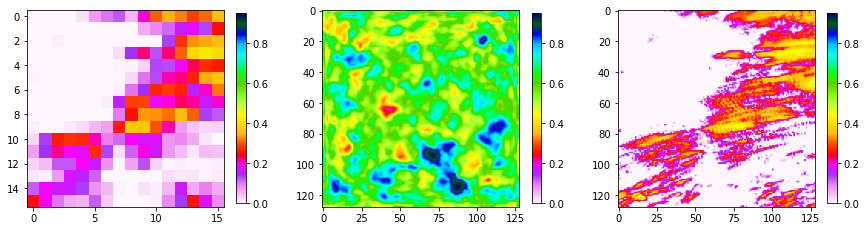

In [86]:
plot_sample(X, y, G, 0)